In [10]:
%matplotlib inline
import numpy as np
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import scipy.constants as c
import csv
from mcerp import N, Gamma, umath

def Gamma_mu_sig(mu,sig):
    k=mu**2/sig**2
    theta=sig**2/mu
    return Gamma(k, theta)
G_uv=lambda q, q_err: np.array([Gamma_mu_sig(qq, qe) for qq, qe in zip(q, q_err)])
N_uv=lambda q, q_err: np.array([N(qq, qe) for qq, qe in zip(q, q_err)])
def gradient(x, y):
    dx=np.diff(x).mean()
    out = np.empty_like(y)
    out[1:-1] = (y[2:] - y[:-2])/2.0
    out[0] = -(3*y[0] - 4*y[1] + y[2]) / 2.0
    out[-1] = (3*y[-1] - 4*y[-2] + y[-3])
    out=out/dx
    return out, dx
def uv_m_std(uv):
    uv_mean=np.array([u.mean for u in uv])
    uv_std=np.array([u.std for u in uv])
    return uv_mean, uv_std

def Harris_B(y, B0, L):
    return B0*np.tanh(y/L)
def Harris_B_uv(y, B0, L):
    return np.array([B0*umath.tanh(yy/L) for yy in y])


In [2]:
y=np.linspace(-3.2e-3,3.2e-3,1e3)
B0=6.25
L=0.7e-3
B=Harris_B(y, B0, L)
j=Harris_j(y, B0, L)
gPB=Harris_gradP(y, B0, L)

In [3]:
cd "~\Google Drive\MAGPIE\data\2015\s0611_15"

C:\Users\jdavies\Google Drive\MAGPIE\data\2015\s0611_15


In [4]:
y_pos=[]
n_e=[]
Z=[]
T_e=[]
T_e_err=[]
T_i=[]
T_i_err=[]
V=[]
V_err=[]

filename='s0611_15 TS fits v3.dat'
with open(filename, 'r') as f:
    reader = csv.reader(f, delimiter='\t')
    next(reader)
    for row in reader:
        y_pos.append(float(row[3]))
        n_e.append(float(row[5]))
        Z.append(float(row[6]))
        T_e.append(float(row[7]))
        tee=float(row[8])
        if tee==0:
            T_e_err.append(float(row[7])/10.0)
        else:
            T_e_err.append(tee)
        T_i.append(float(row[9]))
        tie=float(row[10])
        if tie==0:
            T_i_err.append(float(row[9])/10.0)
        else:
            T_i_err.append(tie)
        V.append(float(row[11]))
        ve=float(row[12])
        if tie==0:
            V_err.append(float(row[11])/10.0)
        else:
            V_err.append(ve)
        
y_pos=np.array(y_pos)*1e-3
n_e=np.array(n_e)
n_e_err=np.zeros_like(n_e)+0.3e17
Z=np.array(Z)
T_e=np.array(T_e)
T_e_err=np.array(T_e_err)
T_i=np.array(T_i)
T_i_err=np.array(T_i_err)
V=np.array(V)
V_err=np.array(V_err)  

In [5]:
cd "~\Google Drive\MAGPIE\data\2015\s0513_15 RECONNECTION - Carbon repeat"

C:\Users\jdavies\Google Drive\MAGPIE\data\2015\s0513_15 RECONNECTION - Carbon repeat


In [6]:
Br=np.loadtxt(open('s0513_15 B.txt',"r"),delimiter=",")
Bm=np.mean(Br[300:600, :],0)
cB=316
Bs=Bm[cB-200:cB+200]-Bm.mean()
y_B=(np.linspace(cB-200,cB+200, 400)-cB)/61.0

In [7]:
PT=(n_e*T_e+n_e/Z*T_i)*1e6*1.6e-19#J/m^3
PR=12*c.m_p*(n_e/Z*1e6)*(V*1e3)**2
PB=B**2/(2*c.mu_0)

PB_r=Bs**2/(2*c.mu_0)
B_i=np.interp(y_pos*1e3, y_B,Bs)
PB_ri=B_i**2/(2*c.mu_0)

B_smooth=savgol_filter(Bs, 61,2)
B_ismooth=np.interp(y_pos*1e3, y_B,B_smooth)
PB_smooth=B_smooth**2/(2*c.mu_0)
PB_ismooth=B_ismooth**2/(2*c.mu_0)

dx=y_pos[1]-y_pos[0]
gPT=np.gradient(PT, dx)
gPB_ri=np.gradient(PB_ri, dx)
gPB_is=np.gradient(PB_ismooth, dx)
dx=y[1]-y[0]
gPB=np.gradient(B**2/(2*c.mu_0), dx)
gPB_i=np.interp(y_pos, y, gPB)
dx=y_B[1]-y_B[0]
gPB_smooth=np.gradient(PB_smooth, dx*1e-3)
gPB_r=np.gradient(PB_r, dx*1e-3)

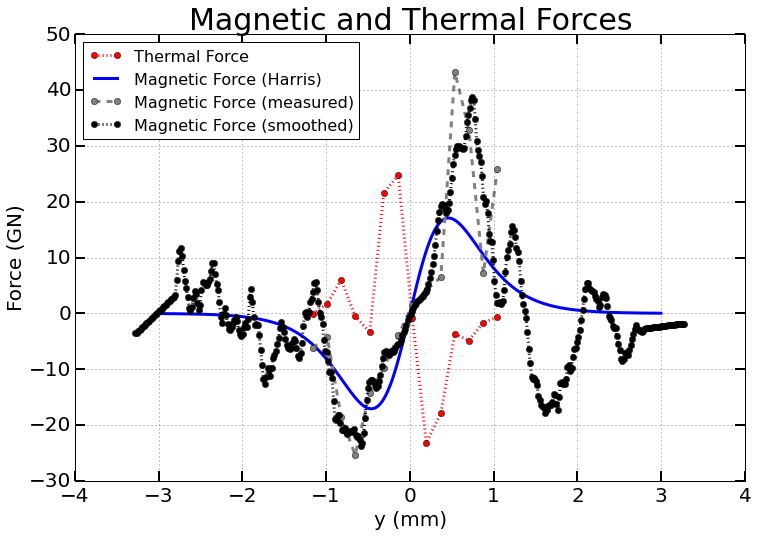

In [75]:
fig, ax=plt.subplots(figsize=(12,8))
ax.plot(y_pos*1e3, gPT/1e9, color='red',lw=3,ls=':', marker='o',label='Thermal Force')
ax.plot(y*1e3, gPB/1e9,color='blue',lw=3,label='Magnetic Force (Harris)')
ax.plot(y_pos*1e3, gPB_ri/1e9,color='grey',lw=3,ls='--', marker='o',label='Magnetic Force (measured)')
ax.plot(y_B, gPB_smooth/1e9,color='black',lw=3,ls=':', marker='o',label='Magnetic Force (smoothed)')


ax.set_xlabel('y (mm)',fontsize=20)
ax.set_ylabel('Force (GN)',fontsize=20)
ax.tick_params(labelsize=20, pad=5, length=10, width=2)
ax.grid()
ax.legend(fontsize=16, loc=2)
#ax.set_ylim([-50,50])

ax.set_title('Magnetic and Thermal Forces', fontsize=30)

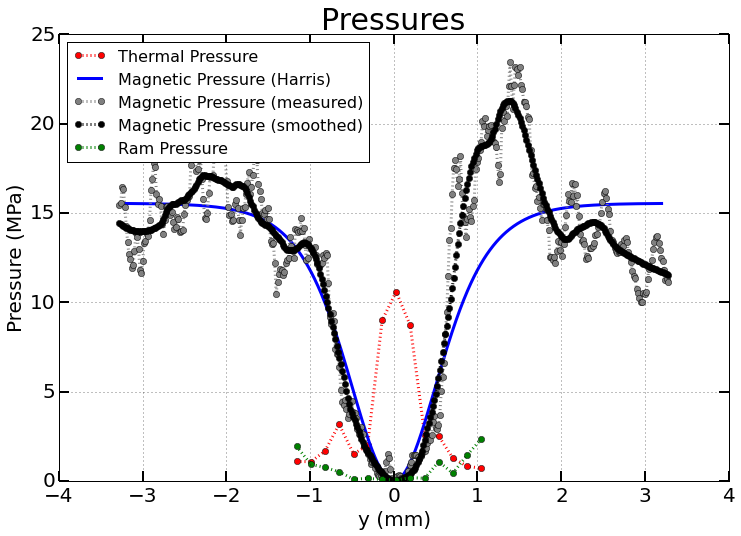

In [78]:
fig, ax=plt.subplots(figsize=(12,8))
ax.plot(y_pos*1e3, PT/1e6, color='red',lw=3,ls=':', marker='o',label='Thermal Pressure')
ax.plot(y*1e3, PB/1e6,color='blue',lw=3,label='Magnetic Pressure (Harris)')
ax.plot(y_B, PB_r/1e6,color='grey',lw=3,ls=':', marker='o',label='Magnetic Pressure (measured)')
ax.plot(y_B, PB_smooth/1e6,color='black',lw=3,ls=':',marker='o',label='Magnetic Pressure (smoothed)')
ax.plot(y_pos*1e3, PR/1e6,color='green',lw=3,ls=':', marker='o',label='Ram Pressure')
ax.set_xlabel('y (mm)',fontsize=20)
ax.set_ylabel('Pressure (MPa)',fontsize=20)
ax.tick_params(labelsize=20, pad=5, length=10, width=2)
ax.grid()
ax.legend(fontsize=16, loc=0)

ax.set_title('Pressures', fontsize=30)

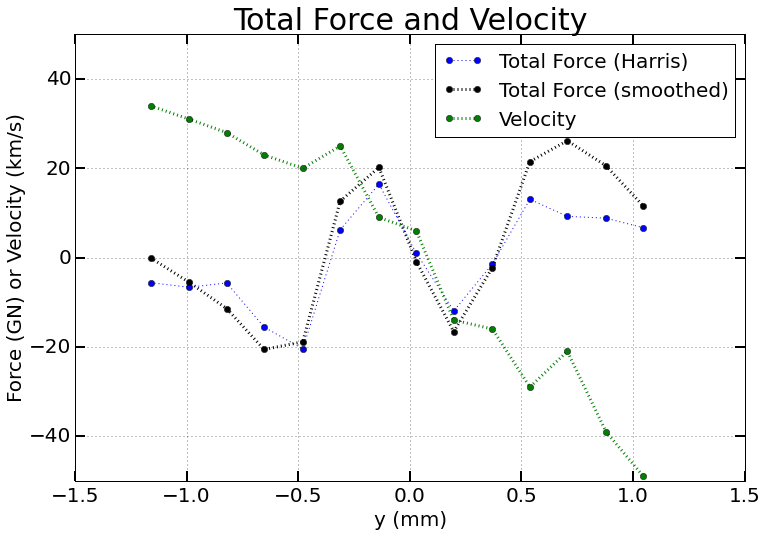

In [84]:
fig, ax=plt.subplots(figsize=(12,8))
ax.plot(y_pos*1e3, (gPB_i+gPT)/1e9, color='blue',lw=1,ls=':', marker='o',label='Total Force (Harris)')
#ax.plot(y_pos*1e3, (gPB_ri+gPT)/1e9, color='grey',lw=3,ls=':', marker='o',label='Total Force (measured)')
ax.plot(y_pos*1e3, (gPB_is+gPT)/1e9, color='black',lw=3,ls=':', marker='o',label='Total Force (smoothed)')

ax.plot(y_pos*1e3, V,color='green',lw=3,ls=':', marker='o',label='Velocity')
ax.set_xlabel('y (mm)',fontsize=20)
ax.set_ylabel('Force (GN) or Velocity (km/s)',fontsize=20)
ax.tick_params(labelsize=20, pad=5, length=10, width=2)
ax.grid()
ax.legend(fontsize=20, loc=0)
ax.set_ylim([-50,50])

ax.set_title('Total Force and Velocity', fontsize=30)

# With Uncertainties

In [8]:
n_e_uv=G_uv(n_e,n_e_err)
T_e_uv=G_uv(T_e,T_e_err)
T_i_uv=G_uv(T_i,T_i_err)
V_uv=N_uv(V,V_err)

In [23]:
PT_uv=(n_e_uv*T_e_uv+n_e_uv/Z*T_i_uv)*1e6*1.6e-19#J/m^3
PR_uv=12*c.m_p*(n_e_uv/Z*1e6)*(V_uv*1e3)**2
PT_m, PT_std=uv_m_std(PT_uv)
PR_m, PR_std=uv_m_std(PR_uv)

y_pos_err=np.zeros_like(y_pos)+5e-5
y_uv=N_uv(y_pos, y_pos_err)

B0_uv=N(6.24, 0.05)
L_uv=N(0.69e-3,0.02e-3)
B_uv=Harris_B_uv(y_uv,B0_uv,L_uv)

PB_uv=B_uv**2/(2*c.mu_0)
PB_m, PB_std=uv_m_std(PB_uv)
PTot=PT_uv+PB_uv
PTot_m, PTot_std=uv_m_std(PTot)

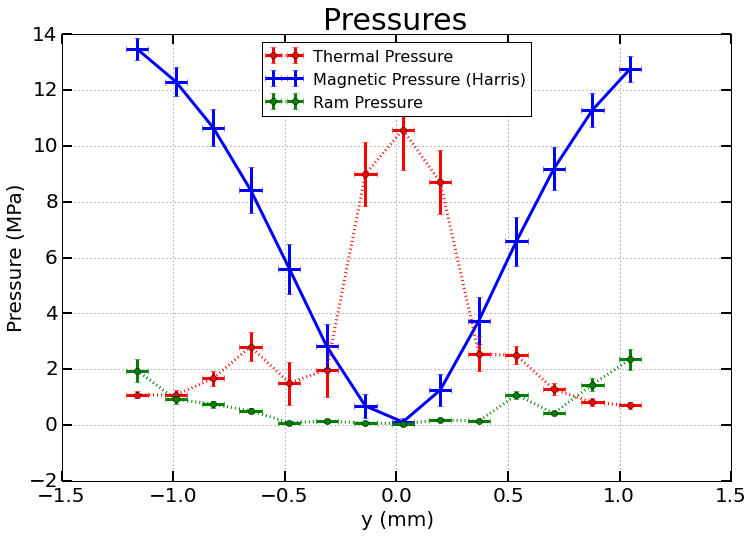

In [24]:
fig, ax=plt.subplots(figsize=(12,8))
ax.errorbar(y_pos*1e3, PT_m/1e6, yerr=PT_std/1e6,xerr=y_pos_err*1e3,color='red',lw=3,ls=':', marker='o',label='Thermal Pressure')
ax.errorbar(y_pos*1e3, PB_m/1e6,yerr=PB_std/1e6,xerr=y_pos_err*1e3,color='blue',lw=3,label='Magnetic Pressure (Harris)')
ax.errorbar(y_pos*1e3, PR_m/1e6,yerr=PR_std/1e6,xerr=y_pos_err*1e3,color='green',lw=3,ls=':', marker='o',label='Ram Pressure')
ax.set_xlabel('y (mm)',fontsize=20)
ax.set_ylabel('Pressure (MPa)',fontsize=20)
ax.tick_params(labelsize=20, pad=5, length=10, width=2)
ax.grid()
ax.legend(fontsize=16, loc=0)

ax.set_title('Pressures', fontsize=30)

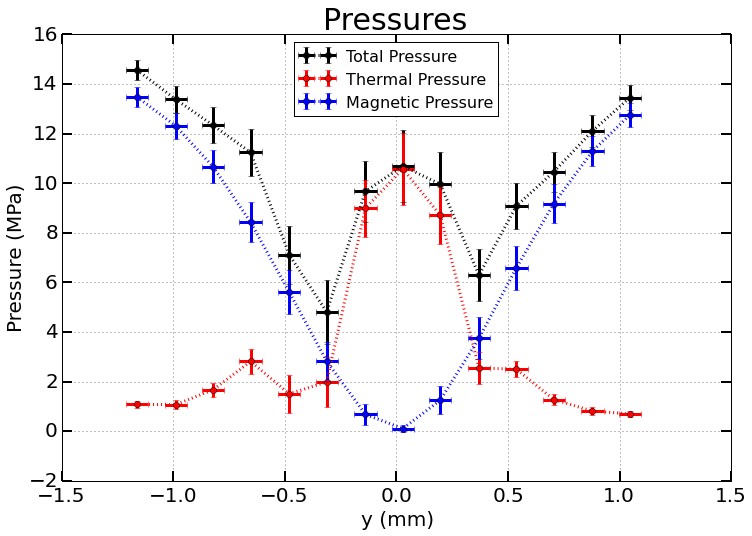

In [25]:
fig, ax=plt.subplots(figsize=(12,8))
ax.errorbar(y_pos*1e3, PTot_m/1e6, yerr=PTot_std/1e6,xerr=y_pos_err*1e3,color='black',lw=3,ls=':', marker='o',label='Total Pressure')
ax.errorbar(y_pos*1e3, PT_m/1e6, yerr=PT_std/1e6,xerr=y_pos_err*1e3,color='red',lw=3,ls=':', marker='o',label='Thermal Pressure')
ax.errorbar(y_pos*1e3, PB_m/1e6, yerr=PB_std/1e6,xerr=y_pos_err*1e3,color='blue',lw=3,ls=':', marker='o',label='Magnetic Pressure')

ax.set_xlabel('y (mm)',fontsize=20)
ax.set_ylabel('Pressure (MPa)',fontsize=20)
ax.tick_params(labelsize=20, pad=5, length=10, width=2)
ax.grid()
ax.legend(fontsize=16, loc=0)

ax.set_title('Pressures', fontsize=30)

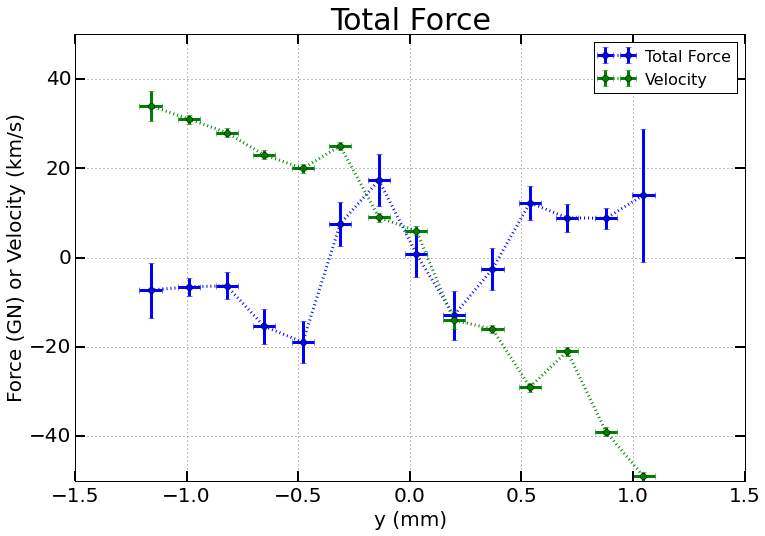

In [28]:
gPTot, dy=gradient(y_uv, PTot)
gPTot_m, gPTot_std=uv_m_std(gPTot)
fig, ax=plt.subplots(figsize=(12,8))
ax.errorbar(y_pos*1e3, gPTot_m/1e9, yerr=gPTot_std/1e9,xerr=y_pos_err*1e3,color='blue',lw=3,ls=':', marker='o',label='Total Force')
ax.errorbar(y_pos*1e3, V,yerr=V_err,xerr=y_pos_err*1e3,color='green',lw=3,ls=':', marker='o',label='Velocity')
ax.set_xlabel('y (mm)',fontsize=20)
ax.set_ylabel('Force (GN) or Velocity (km/s)',fontsize=20)
ax.set_ylim([-50,50])
ax.tick_params(labelsize=20, pad=5, length=10, width=2)
ax.grid()
ax.legend(fontsize=16, loc=0)

ax.set_title('Total Force', fontsize=30)

In [50]:
dKE=np.diff(PR_uv)
Z_av=(Z[1:]+Z[:-1])/2.0
y_av=(y_pos[1:]+y_pos[:-1])/2.0
ne_av=(n_e_uv[1:]+n_e_uv[:-1])/2.0


In [56]:
delta_Pot=dKE/(ne_av*1e6*1.6e-19)
delta_Pot_m,delta_Pot_std=uv_m_std(delta_Pot)

C:\Users\jdavies\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


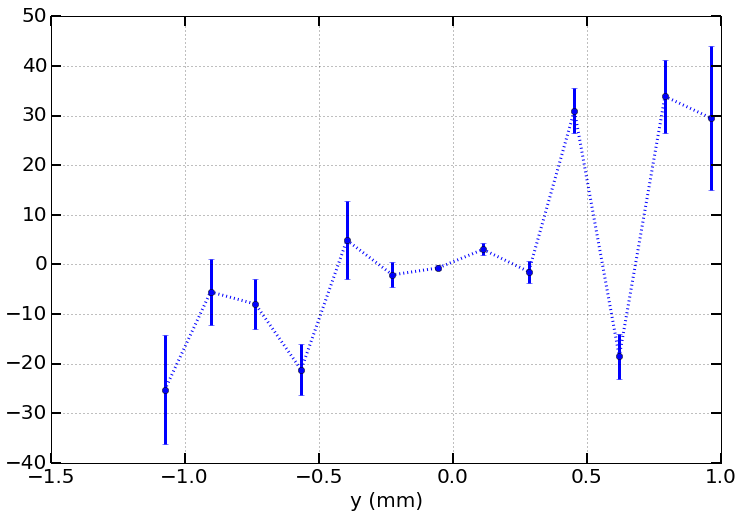

In [57]:
fig, ax=plt.subplots(figsize=(12,8))
ax.errorbar(y_av*1e3, delta_Pot_m, yerr=delta_Pot_std, color='blue',lw=3,ls=':', marker='o')
ax.set_xlabel('y (mm)',fontsize=20)
#ax.set_ylabel('Force (GN) or Velocity (km/s)',fontsize=20)
#ax.set_ylim([-50,50])
ax.tick_params(labelsize=20, pad=5, length=10, width=2)
ax.grid()
ax.legend(fontsize=16, loc=0)

#ax.set_title('Total Force', fontsize=30)

In [54]:
ne_av

array([uv(2.57500017894e+17, 4.47422787655e+32, 0.177424131702, 3.06528425154),
       uv(1.90000003888e+17, 4.40761226342e+32, 0.181092102737, 3.07662390587),
       uv(1.89999489195e+17, 4.47014893421e+32, 0.233956467729, 3.22623076066),
       uv(1.25000595701e+17, 4.54794758248e+32, 0.452619142302, 3.36367920168),
       uv(5.99996521479e+16, 4.46531252905e+32, 0.695499383075, 3.67703185872),
       uv(1.59999022488e+17, 4.48310252465e+32, 0.475228101957, 3.62100455449),
       uv(2.92501261457e+17, 4.48748663155e+32, 0.161078817259, 3.02186531643),
       uv(2.90501172968e+17, 4.4405807657e+32, 0.134955837576, 3.01465545985),
       uv(1.90499743819e+17, 4.51713330669e+32, 0.25515703716, 3.10843684357),
       uv(1.90500461474e+17, 4.49451540364e+32, 0.234664978391, 3.10975580466),
       uv(2.23000733159e+17, 4.4826476774e+32, 0.186775520588, 3.01243368831),
       uv(1.90000124491e+17, 4.52909388655e+32, 0.270520099746, 3.14525564712),
       uv(1.89999666226e+17, 4.46925974216e